In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
train_dataset = utils.image_dataset_from_directory(
'./chest_xray/train',
image_size=(480, 480),
color_mode='grayscale',
batch_size=16)

val_dataset = utils.image_dataset_from_directory(
'./chest_xray/val',
image_size=(480, 480),
color_mode='grayscale',
batch_size=16)

test_dataset = utils.image_dataset_from_directory(
'./chest_xray/test',
image_size=(480, 480),
color_mode='grayscale',
batch_size=16)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [4]:
inputs = keras.Input(shape=(480, 480 ,1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128 ,256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])
    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 480, 480, 1)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 480, 480, 1)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 476, 476, 32  800         ['rescaling[0][0]']          

                                )                                                                 
                                                                                                  
 separable_conv2d_4 (SeparableC  (None, 119, 119, 12  8768       ['activation_4[0][0]']           
 onv2D)                         8)                                                                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 119, 119, 12  512        ['separable_conv2d_4[0][0]']     
 rmalization)                   8)                                                                
                                                                                                  
 activation_5 (Activation)      (None, 119, 119, 12  0           ['batch_normalization_5[0][0]']  
                                8)                                                                
          

In [5]:
model.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=['accuracy'])

In [6]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3),
    keras.callbacks.ModelCheckpoint(
        filepath='my_best_ckpt.keras',
        save_best_only=True,
        monitor='val_loss'),
    keras.callbacks.TensorBoard(
        log_dir='./full_log_dir/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
        histogram_freq=1,
        embeddings_freq=1, 
        update_freq=1)
]

In [7]:
import os 

if os.path.isfile('./my_best_ckpt.keras') is True:
    pass
else:
    history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/30
326/326 [==============================] - 54s 147ms/step - loss: 0.3239 - accuracy: 0.8495 - val_loss: 1.7167 - val_accuracy: 0.5000
Epoch 2/30
326/326 [==============================] - 48s 148ms/step - loss: 0.2635 - accuracy: 0.8838 - val_loss: 0.9372 - val_accuracy: 0.5625
Epoch 3/30
326/326 [==============================] - 48s 147ms/step - loss: 0.2326 - accuracy: 0.8955 - val_loss: 1.4681 - val_accuracy: 0.6250
Epoch 4/30
326/326 [==============================] - 48s 147ms/step - loss: 0.2058 - accuracy: 0.9124 - val_loss: 1.6744 - val_accuracy: 0.5000
Epoch 5/30
326/326 [==============================] - 48s 146ms/step - loss: 0.1887 - accuracy: 0.9229 - val_loss: 0.8778 - val_accuracy: 0.8750
Epoch 6/30
326/326 [==============================] - 48s 148ms/step - loss: 0.1755 - accuracy: 0.9289 - val_loss: 0.3222 - val_accuracy: 0.7500
Epoch 7/30
326/326 [==============================] - 48s 146ms/step - loss: 0.1606 - accuracy: 0.9385 - val_loss: 0.5175 - val_ac

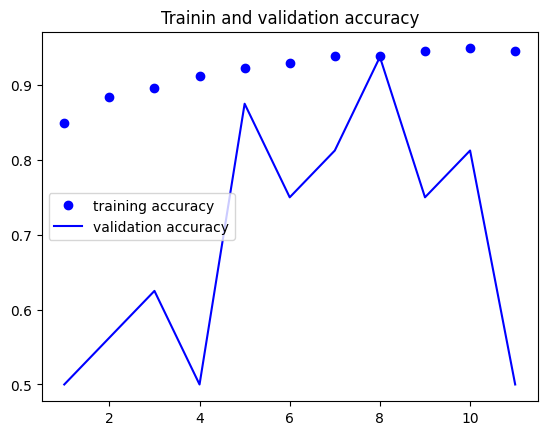

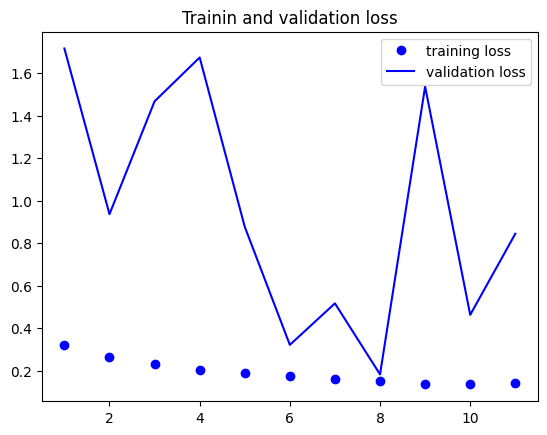

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="training accuracy")
plt.plot(epochs, val_acc, "b", label="validation accuracy")
plt.title("Trainin and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Trainin and validation loss")
plt.legend()
plt.show()

In [10]:
test_model = keras.models.load_model('my_best_ckpt.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

39/39 [==============================] - 1s 32ms/step - loss: 0.3074 - accuracy: 0.8798
테스트 정확도: 0.880


In [11]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir './full_log_dir' --bind_all

In [24]:
img1 = keras.preprocessing.image.load_img('./chest_xray/test/NORMAL/IM-0023-0001.jpeg', target_size=(480,480), color_mode='grayscale')
img2 = keras.preprocessing.image.load_img('./chest_xray/test/PNEUMONIA/person3_virus_17.jpeg', target_size=(480,480), color_mode='grayscale')

In [25]:
x1 = keras.preprocessing.image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = layers.Rescaling(1./255)(x1)

In [26]:
x2 = keras.preprocessing.image.img_to_array(img2)
x2 = np.expand_dims(x2, axis=0)
x2 = layers.Rescaling(1./255)(x2)

In [27]:
y_pred = model.predict(x1)

1/1 [==============================] - 0s 299ms/step


In [28]:
print(y_pred)

[[0.9999994]]


In [29]:
last_conv_layer = model.get_layer('conv2d_5')

In [30]:
model_1= keras.Model(model.inputs, last_conv_layer.output)

In [36]:
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("global_average_pooling2d")(input_2)
x_2 = model.get_layer("dense")(x_2)
model_2=keras.Model(input_2,x_2)

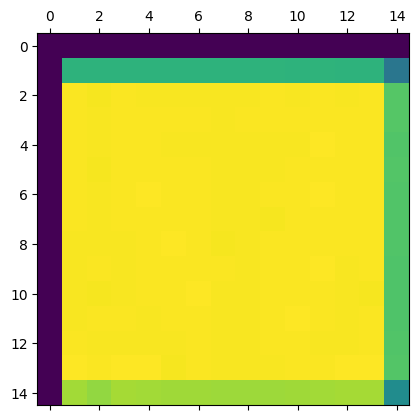

In [37]:
#GradientTape함수를 이용한 그레디언트 계산
with tf.GradientTape() as tape:
    output_1 = model_1(x1)
    tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]

grads = tape.gradient(output_2, output_1) #그레디언트 계산
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #전역 평균 풀링 적용

output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1, axis=-1)

heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화
plt.matshow(heatmap)

plt.show()

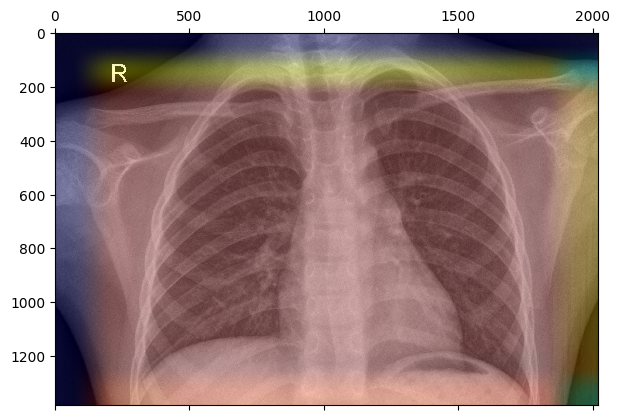

In [38]:

#열지도를 입력 영상에 씌움
img = keras.preprocessing.image.load_img('./chest_xray/test/NORMAL/IM-0023-0001.jpeg') #입력 영상을 다시 받음

img = keras.preprocessing.image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]

color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img= color_heatmap*0.4+img #덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

plt.show()

결과 : 환자의 흉곽 영역에 빨갛게 표시하는 것을 보아 GradCAM이 의사결정 한는것을 확인할 수 있다.